<a href="https://colab.research.google.com/github/bowserd1/California-Housing-Project/blob/main/Data_Wrangling_California_Housing_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from geopy import distance


In [2]:
from google.colab import files


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
housing=pd.read_csv('/content/drive/MyDrive/Colab Data Sets/train.csv')
housing_test=pd.read_csv('/content/drive/MyDrive/Colab Data Sets/test.csv')
cal_cities = pd.read_csv('/content/drive/MyDrive/Colab Data Sets/cal_cities_lat_long.csv')
cal_pops = pd.read_csv('/content/drive/MyDrive/Colab Data Sets/cal_populations_city.csv')

Imoprting the necessary files. This includes the housing data and test set that we are analyzing. I've also gathered one csv with the coordinates of cities in California and another csv with the populations of various cities in California since I think these will impact median home values.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37137 non-null  int64  
 1   MedInc       37137 non-null  float64
 2   HouseAge     37137 non-null  float64
 3   AveRooms     37137 non-null  float64
 4   AveBedrms    37137 non-null  float64
 5   Population   37137 non-null  float64
 6   AveOccup     37137 non-null  float64
 7   Latitude     37137 non-null  float64
 8   Longitude    37137 non-null  float64
 9   MedHouseVal  37137 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.8 MB


In [6]:
housing['bedrooms_per_room']=housing['AveBedrms']/housing['AveRooms']
housing_test['bedrooms_per_room_pct']=housing_test['AveBedrms']/housing_test['AveRooms']

Here I added a feature which calculates the number of bedrooms as a percentage of the total number of rooms.

In [7]:
housing['occupancy_per_room'] = housing['AveOccup']/housing['AveRooms']
housing_test['occupancy_per_room'] = housing_test['AveOccup']/housing_test['AveRooms']

This feature adds the number of occupants per room.

In [8]:
housing['occupancy_per_bedroom'] = housing['AveOccup']/housing['AveBedrms']
housing_test['occupancy_per_bedroom'] = housing_test['AveOccup']/housing_test['AveBedrms']

This feature gives the number of occupants per bedroom.

In [9]:
housing_test.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,bedrooms_per_room_pct,occupancy_per_room,occupancy_per_bedroom
0,37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85,0.220793,0.572735,2.593989
1,37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29,0.262293,0.759539,2.895771
2,37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81,0.134551,0.405206,3.011530
3,37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34,0.219822,0.365556,1.662961
4,37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29,0.287263,0.532182,1.852594


In [10]:
cal_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       459 non-null    object 
 1   Latitude   459 non-null    float64
 2   Longitude  459 non-null    float64
dtypes: float64(2), object(1)
memory usage: 10.9+ KB


In [11]:
cal_pops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   County               455 non-null    object 
 1   City                 455 non-null    object 
 2   Incorportation_date  455 non-null    object 
 3   pop_april_1980       425 non-null    float64
 4   pop_april_1990       455 non-null    int64  
 5   pop_april_2000       455 non-null    int64  
 6   pop_april_2010       455 non-null    int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 25.0+ KB


In [12]:
cal_pop_loc = cal_cities.merge(cal_pops, left_on='Name', right_on='City',how='left')

I am merging two data frames that have the California population data and coordinates. The most necessary columns are 1990 population and the coordinates.

In [13]:
cal_pop_loc.head()

,Name,Latitude,Longitude,County,City,Incorportation_date,pop_april_1980,pop_april_1990,pop_april_2000,pop_april_2010
0,Adelanto,34.582769,-117.409214,San Bernardino,Adelanto,1970,2164.0,8517.0,18130.0,31765.0
1,Agoura Hills,34.153339,-118.761675,Los Angeles,Agoura Hills,1982,NaN,20390.0,20537.0,20330.0
2,Alameda,37.765206,-122.241636,Alameda,Alameda,1854,63852.0,76459.0,72259.0,73812.0
3,Albany,37.886869,-122.297747,Alameda,Albany,1908,15130.0,16327.0,16444.0,18539.0
4,Alhambra,34.095286,-118.127014,Los Angeles,Alhambra,1903,64767.0,82106.0,85804.0,83089.0


In [14]:
cal_pop_loc.drop(['County', 'Incorportation_date', 'pop_april_2000', 'pop_april_2010'], axis=1)

,Name,Latitude,Longitude,City,pop_april_1980,pop_april_1990
0,Adelanto,34.582769,-117.409214,Adelanto,2164.0,8517.0
1,Agoura Hills,34.153339,-118.761675,Agoura Hills,NaN,20390.0
2,Alameda,37.765206,-122.241636,Alameda,63852.0,76459.0
3,Albany,37.886869,-122.297747,Albany,15130.0,16327.0
4,Alhambra,34.095286,-118.127014,Alhambra,64767.0,82106.0
...,...,...,...,...,...,...
454,Woodland,38.678517,-121.773297,Woodland,30235.0,39802.0
455,Yorba Linda,33.888625,-117.813111,Yorba Linda,28254.0,52422.0
456,Yreka,41.735419,-122.634472,Yreka,5916.0,6948.0
457,Yuba City,39.140447,-121.616911,Yuba City,18736.0,27437.0


Many of the columns are unneccessary, so I dropped them.

In [15]:
cal_pop_cities = cal_pop_loc[cal_pop_loc['pop_april_1990'] > 250000]

Next I filtered out any cities under 250,000. I expect that bigger cities have a much larger impact on median home values.

In [16]:
cal_pop_cities=cal_pop_cities.drop(['County', 'Incorportation_date', 'pop_april_2000', 'pop_april_2010','Name'], axis=1)
cal_pop_cities = cal_pop_cities.reset_index(drop=True)

I dropped more unnecessary columns here.

In [17]:
cal_pop_cities

,Latitude,Longitude,City,pop_april_1980,pop_april_1990
0,33.835292,-117.914503,Anaheim,219494.0,266406.0
1,36.746842,-119.772586,Fresno,217129.0,354202.0
2,33.768322,-118.195617,Long Beach,361355.0,429433.0
3,34.052233,-118.243686,Los Angeles,2968579.0,3485398.0
4,37.804364,-122.271114,Oakland,339337.0,372242.0
5,38.581572,-121.494400,Sacramento,275741.0,369365.0
6,32.715328,-117.157256,San Diego,875538.0,1110549.0
7,37.774931,-122.419417,San Francisco,678974.0,723959.0
8,37.339386,-121.894956,San Jose,629531.0,782248.0
9,33.745572,-117.867833,Santa Ana,204023.0,293742.0


In [18]:
housing_coords = housing.iloc[:, [7,8]]
housing['housing_tuple'] = housing_coords.apply(tuple, axis=1)
city_coords = cal_pop_cities.loc[:, ('Latitude','Longitude')]

In [19]:
city_coords = cal_pop_cities.loc[:, ('Latitude','Longitude')]
city_tuple=city_coords.apply(tuple, axis=1)
cal_pop_cities['coordinates'] = city_tuple

In [20]:
cal_pop_cities = cal_pop_cities.reset_index()

I added a colum in each dataframe that combines the Latitude and Longitude into one tuple which will be easier to access later, then reset the index of the dataframe containing the cities.

In [21]:
for i in range(len(cal_pop_cities)):
  a = housing['housing_tuple'][0]
  b= cal_pop_cities['coordinates'][i]
  print(cal_pop_cities['City'][i], distance.distance(a,b).miles)

Anaheim 136.8374009705468
Fresno 149.29409291417028
Long Beach 124.24175144695015
Los Angeles 113.74368565790147
Oakland 251.5018412503312
Sacramento 284.97086398578807
San Diego 214.52618772820674
San Francisco 253.82325111211955
San Jose 213.45575456966128
Santa Ana 141.82395773769437


Now, I tested the changes I've made to make sure it works as expected, and we can see that for the first entry in our housing data frame, I printed its distance in miles to every city in California that had a population greater than 250,000 in 1990.

In [22]:
housing.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,bedrooms_per_room,occupancy_per_room,occupancy_per_bedroom,housing_tuple
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,0.290581,0.649826,2.236300,"(34.6, -120.12)"
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,0.175312,0.634101,3.616983,"(38.69, -121.22)"
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,0.168795,0.377104,2.234099,"(34.71, -120.45)"
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,0.288171,0.623630,2.164094,"(32.66, -117.09)"
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,0.249567,0.374566,1.500861,"(37.8, -122.41)"


In [23]:
cal_pop_cities.head(9)

,index,Latitude,Longitude,City,pop_april_1980,pop_april_1990,coordinates
0,0,33.835292,-117.914503,Anaheim,219494.0,266406.0,"(33.835292, -117.914503)"
1,1,36.746842,-119.772586,Fresno,217129.0,354202.0,"(36.746842, -119.772586)"
2,2,33.768322,-118.195617,Long Beach,361355.0,429433.0,"(33.768322, -118.195617)"
3,3,34.052233,-118.243686,Los Angeles,2968579.0,3485398.0,"(34.052233, -118.243686)"
4,4,37.804364,-122.271114,Oakland,339337.0,372242.0,"(37.804364, -122.271114)"
5,5,38.581572,-121.494400,Sacramento,275741.0,369365.0,"(38.581572, -121.4944)"
6,6,32.715328,-117.157256,San Diego,875538.0,1110549.0,"(32.715328, -117.157256)"
7,7,37.774931,-122.419417,San Francisco,678974.0,723959.0,"(37.774931, -122.419417)"
8,8,37.339386,-121.894956,San Jose,629531.0,782248.0,"(37.339386, -121.894956)"


In [24]:
housing['key'] = 1
cal_pop_cities['key'] = 1

In [54]:
housing['Miles_to_City'] = ''
housing['Nearest_City'] = ''

for i in range(len(housing)):
  dist=1000
  for j in range(len(cal_pop_cities)):
    a = housing['housing_tuple'][i]
    b= cal_pop_cities['coordinates'][j]
    x=distance.distance(a,b).miles
    if x < dist:
      dist = x
      housing['Miles_to_City'][i] = dist
      housing['Nearest_City'][i] = cal_pop_cities['City'][j]



<ipython-input-54-a6c241f611fe>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing['Miles_to_City'][i] = dist
<ipython-input-54-a6c241f611fe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing['Nearest_City'][i] = cal_pop_cities['City'][j]


In [55]:
housing.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,bedrooms_per_room,occupancy_per_room,occupancy_per_bedroom,housing_tuple,Miles_to_City,Nearest_City
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,0.290581,0.649826,2.236300,"(34.6, -120.12)",113.743686,Los Angeles
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,0.175312,0.634101,3.616983,"(38.69, -121.22)",16.62312,Sacramento
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,0.168795,0.377104,2.234099,"(34.71, -120.45)",133.985533,Los Angeles
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,0.288171,0.623630,2.164094,"(32.66, -117.09)",5.467741,San Diego
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,0.249567,0.374566,1.500861,"(37.8, -122.41)",1.80414,San Francisco


In [56]:
cal_pop_cities

,index,Latitude,Longitude,City,pop_april_1980,pop_april_1990,coordinates
0,0,33.835292,-117.914503,Anaheim,219494.0,266406.0,"(33.835292, -117.914503)"
1,1,36.746842,-119.772586,Fresno,217129.0,354202.0,"(36.746842, -119.772586)"
2,2,33.768322,-118.195617,Long Beach,361355.0,429433.0,"(33.768322, -118.195617)"
3,3,34.052233,-118.243686,Los Angeles,2968579.0,3485398.0,"(34.052233, -118.243686)"
4,4,37.804364,-122.271114,Oakland,339337.0,372242.0,"(37.804364, -122.271114)"
5,5,38.581572,-121.494400,Sacramento,275741.0,369365.0,"(38.581572, -121.4944)"
6,6,32.715328,-117.157256,San Diego,875538.0,1110549.0,"(32.715328, -117.157256)"
7,7,37.774931,-122.419417,San Francisco,678974.0,723959.0,"(37.774931, -122.419417)"
8,8,37.339386,-121.894956,San Jose,629531.0,782248.0,"(37.339386, -121.894956)"
9,9,33.745572,-117.867833,Santa Ana,204023.0,293742.0,"(33.745572, -117.867833)"


In [57]:
housing = housing.merge(cal_pop_cities[['pop_april_1990','City']], left_on='Nearest_City', right_on='City',how='left')

In [58]:
housing = housing.drop('City', axis=1)

In [59]:
housing.head(15)

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,bedrooms_per_room,occupancy_per_room,occupancy_per_bedroom,housing_tuple,Miles_to_City,Nearest_City,pop_april_1990
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,0.290581,0.649826,2.236300,"(34.6, -120.12)",113.743686,Los Angeles,3485398.0
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,0.175312,0.634101,3.616983,"(38.69, -121.22)",16.62312,Sacramento,369365.0
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,0.168795,0.377104,2.234099,"(34.71, -120.45)",133.985533,Los Angeles,3485398.0
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,0.288171,0.623630,2.164094,"(32.66, -117.09)",5.467741,San Diego,1110549.0
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,0.249567,0.374566,1.500861,"(37.8, -122.41)",1.80414,San Francisco,723959.0
5,5,6.8075,26.0,6.764372,1.091787,2147.0,2.703540,33.84,-118.31,3.714,0.161403,0.399673,2.476251,"(33.84, -118.31)",8.229076,Long Beach,429433.0
6,6,2.3654,21.0,4.734884,1.011396,1112.0,2.937247,35.65,-117.64,0.811,0.213605,0.620342,2.904153,"(35.65, -117.64)",115.3579,Los Angeles,3485398.0
7,7,2.3562,31.0,5.186567,1.154229,1346.0,3.348259,32.68,-117.07,0.824,0.222542,0.645564,2.900862,"(32.68, -117.07)",5.636883,San Diego,1110549.0
8,8,2.2672,23.0,4.640155,1.064302,628.0,1.774461,38.53,-121.43,0.995,0.229368,0.382414,1.667254,"(38.53, -121.43)",4.982018,Sacramento,369365.0
9,9,5.6370,20.0,4.391863,1.053312,1634.0,2.681388,33.88,-118.36,2.291,0.239833,0.610535,2.545674,"(33.88, -118.36)",12.192532,Long Beach,429433.0


Here, I merged the city populations are in the housing data frame. The housing data frame now shows the nearest city to the housing block, its distance from that city and the population of that city.

In [60]:
housing['Pop_To_Miles_Ratio'] = housing['pop_april_1990']/housing['Miles_to_City']

I also added a column with the ratio of size of the city to the miles to the nearest city.

In [61]:
housing.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,bedrooms_per_room,occupancy_per_room,occupancy_per_bedroom,housing_tuple,Miles_to_City,Nearest_City,pop_april_1990,Pop_To_Miles_Ratio
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,0.290581,0.649826,2.236300,"(34.6, -120.12)",113.743686,Los Angeles,3485398.0,30642.562529
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,0.175312,0.634101,3.616983,"(38.69, -121.22)",16.62312,Sacramento,369365.0,22219.956696
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,0.168795,0.377104,2.234099,"(34.71, -120.45)",133.985533,Los Angeles,3485398.0,26013.241273
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,0.288171,0.623630,2.164094,"(32.66, -117.09)",5.467741,San Diego,1110549.0,203109.299308
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,0.249567,0.374566,1.500861,"(37.8, -122.41)",1.80414,San Francisco,723959.0,401276.469854


In [62]:
mean_vals_by_city = housing.groupby('Nearest_City')[['MedHouseVal']].mean()
print(mean_vals_by_city)

               MedHouseVal
Nearest_City              
Anaheim           1.748567
Fresno            0.920885
Long Beach        2.393861
Los Angeles       2.429232
Oakland           2.057476
Sacramento        1.167937
San Diego         1.735239
San Francisco     2.958733
San Jose          2.601559
Santa Ana         2.147207


In [63]:
counts_by_city = housing.groupby('Nearest_City')[['MedHouseVal']].count().sort_values('MedHouseVal', ascending = False)
print(counts_by_city)

               MedHouseVal
Nearest_City              
Los Angeles           9671
Sacramento            4362
San Jose              4027
Anaheim               3571
Oakland               3316
San Diego             3032
Santa Ana             2674
San Francisco         2368
Long Beach            2244
Fresno                1872


One other thing to check for is to see how impactful the nearest city is to the home value. Is the area around each city a substantially different market from the rest of the cities. A couple quick summary statistics show us that the markets are different, by Los Angeles takes up a significant proportion of our data. The boxplot is below, which shows more of the differences in the different markets. What doesn't show up in the boxplot below is that Los Angeles accounts for 26% of the data.
This could be important and we'll look more into this during EDA.

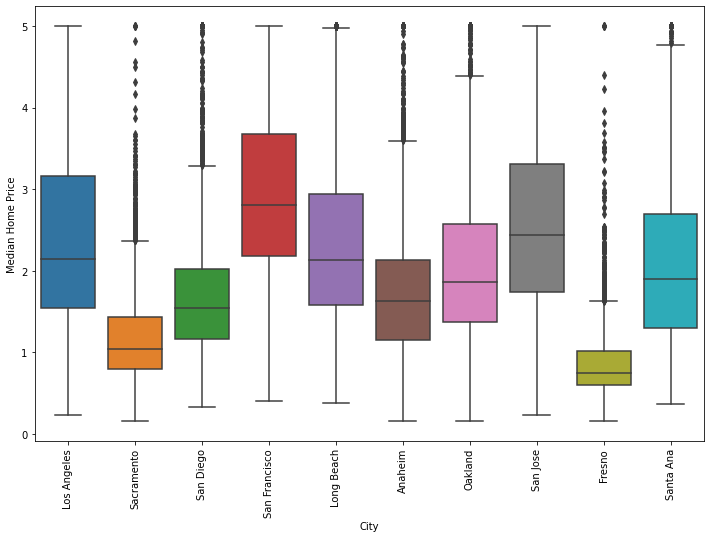

In [64]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Nearest_City', y='MedHouseVal', data=housing)
plt.xticks(rotation='vertical')
plt.ylabel('Median Home Price')
plt.xlabel('City');

In [65]:
housing.to_csv('housing_wrangled.csv')
housing_test.to_csv('housing_test_features.csv')
files.download('housing_wrangled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
!cp housing_wrangled.csv "/content/housing_wrangled.csv"

cp: 'housing_wrangled.csv' and '/content/housing_wrangled.csv' are the same file
